# EpiPINN

Physics-informed neural network learning epidemiological parameters

### Antonio Jimenez AOJ268
### Ashton Cole AVC687

## Contents

- Definitions
- Experiments
    - Experiment 1: Parameter estimation with exact data
    - Experiment 2: Parameter estimation with noisy data
    - Experiment 3: Parameter estimation and forecasting with noisy limited data

## Definitions

In [1]:
from caputo import caputo_euler
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class PINN(nn.Module):
    def __init__(self, hidden_size, depth):
        super().__init__()
        # input t
        layers = [nn.Linear(1, hidden_size), nn.Tanh()]
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        # Output layer with 5 units for (s, e, i, r, d)
        layers.append(nn.Linear(hidden_size, 5))
        # Add softmax to enforce all components are positive and sum to 1
        layers.append(nn.Softmax(dim=1))
        
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

In [3]:
# Credit Google Gemini
def toeplitz(c, r):
    """
    Creates a Toeplitz matrix from a given first column (c) and first row (r).

    Args:
        c (torch.Tensor): A 1D tensor representing the first column of the Toeplitz matrix.
        r (torch.Tensor): A 1D tensor representing the first row of the Toeplitz matrix.
                          The first element of r should be equal to the first element of c.

    Returns:
        torch.Tensor: The constructed Toeplitz matrix.
    """
    if c[0] != r[0]:
        raise ValueError("The first element of 'c' and 'r' must be the same.")

    vals = torch.cat((r, c[1:].flip(0)))
    shape = len(c), len(r)
    i, j = torch.ones(*shape).nonzero().T
    return vals[j - i].reshape(*shape)

In [4]:
def torch_caputo_l1_diff(psis, alpha, dt=1.0, ts=None):
    """Compute approximate Caputo fractional derivative using the L1 scheme.

    Args:
        psi (torch.tensor): A series of function values. In agreement with pytorch machine learning conventions, this tensor is two-dimensional, and the first dimension corresponds to the dependent variable.
        alpha (torch.tensor): The order of the derivative, in the range (0.0, 1.0].
        dt=1.0 (float): If the corresponding dependent variable series is not provided, the uniform step size between function evaluations.
        ts=None (np.ndarray): The corresponding dependent variable series, used if there is a variable step size.

    Returns:
        An torch.tensor containing the series of fractional derivatives.
    """
    psips = torch.zeros(psis.shape, dtype=psis.dtype, device=psis.device)
    C = dt ** (-alpha) / torch.exp(torch.lgamma(2.0 - alpha))
    dpsis = psis[1:, :] - psis[:-1, :]
    if ts is None:
        rs = torch.arange(psis.shape[0] - 1, dtype=psis.dtype, device=psis.device)
        ws = (rs + 1) ** (1.0 - alpha) - rs ** (1.0 - alpha)
        row = torch.zeros(psis.shape[0] - 1, dtype=psis.dtype, device=psis.device)
        row[0] = ws[0] # Lower triangular matrix
        A = toeplitz(ws, row)
        psips[1:, :] = C * A @ dpsis
    else:
        raise NotImplementedError('Variable time step differentiation not yet implemented!')
    return psips

In [5]:
def caputo_l1_diff_broken(psi, alpha, dt):
    n = len(psi)
    # The derivative at t=0 is undefined for the L1 scheme
    derivatives = [torch.zeros(1, 1, device=psi.device)] 
    
    # Pre-compute the log of the gamma function part for stability
    log_gamma_term = torch.lgamma(2.0 - alpha)

    for i in range(1, n):
        # Make vector of k values from 0 to i-1
        k = torch.arange(i, dtype=torch.float32, device=psi.device)
        
        # Calculate weights c_k^(i) 
        weights = ((k + 1)**(1 - alpha) - k**(1 - alpha))
        
        # Get the differences psi(t_{i-k}) - psi(t_{i-k-1})
        psi_diffs = psi[i - k.long()] - psi[i - k.long() - 1]
        
        summation = torch.sum(weights * psi_diffs.squeeze())
        
        # Combine everything to get the derivative at time t_i
        deriv_at_i = (1.0 / (dt**alpha * torch.exp(log_gamma_term))) * summation
        derivatives.append(deriv_at_i.unsqueeze(0))
        
    return torch.cat(derivatives).unsqueeze(1)

In [6]:
class EpiPINN(nn.Module):
    def __init__(self, hidden_size, depth, initial_params):
        super().__init__()
        
        self.pinn = PINN(hidden_size, depth) 
        # trainable params
        # x + torch.log(-torch.expm1(-x))
        self.raw_beta = nn.Parameter(torch.tensor([initial_params['beta'] + np.log(-np.expm1(-initial_params['beta']))], dtype=torch.float32))
        self.raw_sigma = nn.Parameter(torch.tensor([initial_params['sigma'] + np.log(-np.expm1(-initial_params['sigma']))], dtype=torch.float32))
        self.raw_gamma = nn.Parameter(torch.tensor([initial_params['gamma'] + np.log(-np.expm1(-initial_params['gamma']))], dtype=torch.float32))
        self.raw_mu = nn.Parameter(torch.tensor([initial_params['mu'] + np.log(-np.expm1(-initial_params['mu']))], dtype=torch.float32))
        # Init z_alpha such that the init alpha is close to 1.0
        self.z_alpha = nn.Parameter(torch.tensor([initial_params['z_alpha']], dtype=torch.float32)) # sigmoid(2.94) is approx 0.95
        
        self.min_alpha = initial_params['min_alpha'] # Example minimum value for alpha
        self.dt = initial_params['dt']

    def beta(self):
        return nn.functional.softplus(self.raw_beta)

    def sigma(self):
        return nn.functional.softplus(self.raw_sigma)

    def gamma(self):
        return nn.functional.softplus(self.raw_gamma)
        
    def mu(self):
        return nn.functional.softplus(self.raw_mu)

    def alpha(self):
        # Restrict alpha to a specific range, (min_alpha, 1.0] 
        return self.min_alpha + (1.0 - self.min_alpha) * torch.sigmoid(self.z_alpha)
    
    def forward(self, t):
        return self.pinn(t)

    def get_loss_ic(self, ts, ic, y_pred=None):
        """Get initial condition loss of model.

        Arguments:
            ts (torch.tensor): Time points for the model, assuming t[0] is the initial time. Only t[0] is needed, but the tensor dimensions must be consistent.
            ic (torch.tensor): The initial state to enforce.
            y_pred=None (torch.tensor): Predictions at time points, if already computed. Only y[0] is needed, but the tensor dimensions must be consistent.

        Returns:
            squared l2 norm of initial condition error
        """
        # IC loss
        t_initial = ts[0].unsqueeze(0) # get t_0
        y_initial_pred = self.forward(t_initial) if y_pred == None else y_pred[0, :].unsqueeze(0)
        return nn.functional.mse_loss(y_initial_pred, ic)

    def get_loss_data(self, t_data, y_data, y_data_pred=None):
        """Get data loss of model.

        Arguments:
            t_data (torch.tensor): Training data times.
            y_data (torch.tensor): Corresponding state data.
            y_data_pred=None (torch.tensor): Predictions at data points, if already computed.

        Returns:
            MSE loss (squared l2 norm) of data error
        """
        # Data Loss
        y_data_pred = self.forward(t_data) if y_data_pred == None else y_data_pred
        return nn.functional.mse_loss(y_data_pred, y_data)

    def get_loss_phys(self, t_colloc, y_colloc_pred=None):
        """Get physics loss of model.

        Arguments:
            t_colloc (torch.tensor): Times at which to compute the loss.
            y_colloc_pred=None (torch.tensor): Predictions at collocation points, if already computed.

        Returns:
            squared l2 norm of residual
        """
        # Phys Loss
        y_colloc_pred = self.forward(t_colloc)
        s,e,i,r,d = y_colloc_pred.unbind(1)
        s = s.unsqueeze(1)
        e = e.unsqueeze(1)
        i = i.unsqueeze(1)
        r = r.unsqueeze(1)
        d = d.unsqueeze(1)
        ds_dt = torch_caputo_l1_diff(s, self.alpha(), self.dt)
        de_dt = torch_caputo_l1_diff(e, self.alpha(), self.dt)
        di_dt = torch_caputo_l1_diff(i, self.alpha(), self.dt)
        dr_dt = torch_caputo_l1_diff(r, self.alpha(), self.dt)
        dd_dt = torch_caputo_l1_diff(d, self.alpha(), self.dt)

        # calculate RHS of equation 4
        num_living =  1 - d
        f_s = -self.beta() * s * i / num_living
        f_e = (self.beta() * s * i / num_living) - self.sigma() * e
        f_i = (self.sigma() * e) - (self.gamma()+ self.mu()) * i
        f_r = self.gamma() * i
        f_d = self.mu() * i

        # calc residuals (LHS - RHS = 0)
        residual_s = ds_dt - f_s
        residual_e = de_dt - f_e
        residual_i = di_dt - f_i
        residual_r = dr_dt - f_r
        residual_d = dd_dt - f_d

        all_residuals = torch.cat([residual_s, residual_e, residual_i, residual_r, residual_d], dim=1)
        loss_phys = torch.mean(all_residuals**2)
        return loss_phys

In [7]:
def train_stage1(model, ts, ys, t_colloc, ic, optimizer, epochs=1000, pr=0):
    """Stage one of EpiPINN training process.

    In this stage, only the weights of the neural network are trained to minimize the data and initial condition loss.

    Arguments:
        model (EpiPINN): An instantiated fractional SEIRD model to train.
        ts (torch.tensor): Time values for time-series data.
        ys (torch.tensor): States (s, e, i, r, d) for time-series data.
        optimizer: Pytorch training optimizer.
        epochs=1000 (Int): How many epochs to perform gradient descent.
        pr=0 (Int): Print progress every pr epochs. If 0, nothing is printed.

    Returns:
        losses, losses_data, losses_ic, losses_phys
    """
    losses = []
    losses_data = []
    losses_ic = []
    losses_phys = []

    # Ensure epidemiological parameters are not trained
    model.raw_beta.requires_grad = False
    model.raw_sigma.requires_grad = False
    model.raw_gamma.requires_grad = False
    model.raw_mu.requires_grad = False
    model.z_alpha.requires_grad = False

    # Set to training mode
    model.train()

    for epoch in range(epochs):
        predictions = model(ts)
        
        # Compute losses separately, then combine
        loss_data = model.get_loss_data(ts, ys, y_data_pred=predictions)
        loss_ic = model.get_loss_ic(t_colloc, ic, y_pred=predictions)
        loss_phys = model.get_loss_phys(t_colloc)
        loss = loss_data + loss_ic # Physics is not used for gradient descent

        # Record losses
        losses.append(loss.item() + loss_phys.item()) # Physics is recored, not mimimized
        losses_data.append(loss_data.item())
        losses_ic.append(loss_ic.item())
        losses_phys.append(loss_phys.item())

        # Adjust weights to minimize loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress if desired
        if pr != 0 and (epoch + 1) % pr == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')
    
    # Set to evaluation mode
    model.eval()
        
    return losses, losses_data, losses_ic, losses_phys

In [8]:
def train_stage2(model, ts, ys, t_colloc, ic, optimizer, epochs=1000, pr=0):
    """Stage two of EpiPINN training process.

    In this stage, both the weights of the neural network and epidemiological parameters are trained to minimize the data, initial condition, and physics losses.

    Arguments:
        model (EpiPINN): An instantiated fractional SEIRD model to train.
        ts (torch.tensor): Time values for time-series data.
        ys (torch.tensor): States (s, e, i, r, d) for time-series data.
        optimizer: Pytorch training optimizer.
        epochs=1000 (Int): How many epochs to perform gradient descent.
        pr=0 (Int): Print progress every pr epochs. If 0, nothing is printed.

    Returns:
        losses, losses_data, losses_ic, losses_phys, alphas, betas, sigmas, gammas, mus
    """
    losses = []
    losses_data = []
    losses_ic = []
    losses_phys = []
    alphas = []
    betas = []
    sigmas = []
    gammas = []
    mus = []

    # Ensure epidemiological parameters are trained
    model.raw_beta.requires_grad = True
    model.raw_sigma.requires_grad = True
    model.raw_gamma.requires_grad = True
    model.raw_mu.requires_grad = True
    model.z_alpha.requires_grad = True

    # Set to training mode
    model.train()

    for epoch in range(epochs):
        predictions = model(ts)
        
        # Compute losses separately, then combine
        loss_data = model.get_loss_data(ts, ys, y_data_pred=predictions)
        loss_ic = model.get_loss_ic(t_colloc, ic, y_pred=predictions)
        loss_phys = model.get_loss_phys(t_colloc)
        loss = loss_data + loss_ic + loss_phys

        # Record losses
        losses.append(loss.item())
        losses_data.append(loss_data.item())
        losses_ic.append(loss_ic.item())
        losses_phys.append(loss_phys.item())

        # Record epidemiological parameters
        alphas.append(model.alpha().item())
        betas.append(model.beta().item())
        sigmas.append(model.sigma().item())
        gammas.append(model.gamma().item())
        mus.append(model.mu().item())

        # Adjust weights to minimize loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress if desired
        if pr != 0 and (epoch + 1) % pr == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')

    # Set to evaluation mode
    model.eval()
    
    return losses, losses_data, losses_ic, losses_phys, alphas, betas, sigmas, gammas, mus

## Experiments

### Experiment 1: Parameter estimation with exact data

This experiment is a recreation of the Mpox synthetic case found in the paper. We were unable to find the synthetic time series data $(s, e, i, r, d)(t)$ from the cited source, so we instead implemented a fractional ODE solver to generate data consistent with the provided epidemiological parameters.

In [9]:
# Data generation
alpha_true = 0.95 # Derivative fraction used for data
beta_true = 0.25 # Infection rate used for model
sigma_true = 0.13 # Incubation rate used for model
gamma_true = 0.052 # Recovery rate used for model
mu_true = 0.005 # Death rate used for model
y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys, dtype=torch.float32)

D[s] = -0.0, s = 0.99
D[s] = -0.0007841305629861977, s = 0.9880890109096844
D[s] = -0.0011552957512042438, s = 0.9854036530858722
D[s] = -0.0014747388145720337, s = 0.9820474532817111
D[s] = -0.0018058120831112349, s = 0.9779884712069988
D[s] = -0.002177553004133218, s = 0.9731325089097256
D[s] = -0.0026069520732444483, s = 0.9673501488153666
D[s] = -0.0031074122108668404, s = 0.9604842071003005
D[s] = -0.0036914567130479645, s = 0.952351374039053
D[s] = -0.004371563257419124, s = 0.94274221864231
D[s] = -0.005160200306680222, s = 0.9314212831716681
D[s] = -0.006069391183102033, s = 0.9181282811684137
D[s] = -0.007109877002992552, s = 0.9025812701711294
D[s] = -0.008289861267395766, s = 0.8844827160715232
D[s] = -0.009613298609109951, s = 0.8635294474068337
D[s] = -0.011077713820837881, s = 0.8394275164141722
D[s] = -0.012671605298781214, s = 0.8119128391381225
D[s] = -0.014371607265886066, s = 0.7807780616211963
D[s] = -0.016139761945860632, s = 0.7459052677418145
D[s] = -0.0179214749

In [10]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.95 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.25 # Infection rate used for model
sigma_guess = 0.13 # Incubation rate used for model
gamma_guess = 0.052 # Recovery rate used for model
mu_guess = 0.005 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model1 = EpiPINN(hidden_size, depth, initial_params)

In [11]:
# Load model if already generated

In [12]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-2),
    epochs=5000,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/5000], Loss: 0.001006
Epoch [200/5000], Loss: 0.000336
Epoch [300/5000], Loss: 0.000111
Epoch [400/5000], Loss: 0.000050
Epoch [500/5000], Loss: 0.000013
Epoch [600/5000], Loss: 0.000010
Epoch [700/5000], Loss: 0.000007
Epoch [800/5000], Loss: 0.000008
Epoch [900/5000], Loss: 0.000005
Epoch [1000/5000], Loss: 0.000045
Epoch [1100/5000], Loss: 0.000003
Epoch [1200/5000], Loss: 0.000003
Epoch [1300/5000], Loss: 0.000103
Epoch [1400/5000], Loss: 0.000002
Epoch [1500/5000], Loss: 0.000006
Epoch [1600/5000], Loss: 0.000003
Epoch [1700/5000], Loss: 0.000084
Epoch [1800/5000], Loss: 0.000004
Epoch [1900/5000], Loss: 0.000027
Epoch [2000/5000], Loss: 0.000036
Epoch [2100/5000], Loss: 0.000036
Epoch [2200/5000], Loss: 0.000005
Epoch [2300/5000], Loss: 0.000001
Epoch [2400/5000], Loss: 0.000010
Epoch [2500/5000], Loss: 0.000005
Epoch [2600/5000], Loss: 0.000001
Epoch [2700/5000], Loss: 0.000015
Epoch [2800/5000], Loss: 0.000067
Epoch [2900/5000], Loss: 0.000086
Epoch [3000/5000], Loss

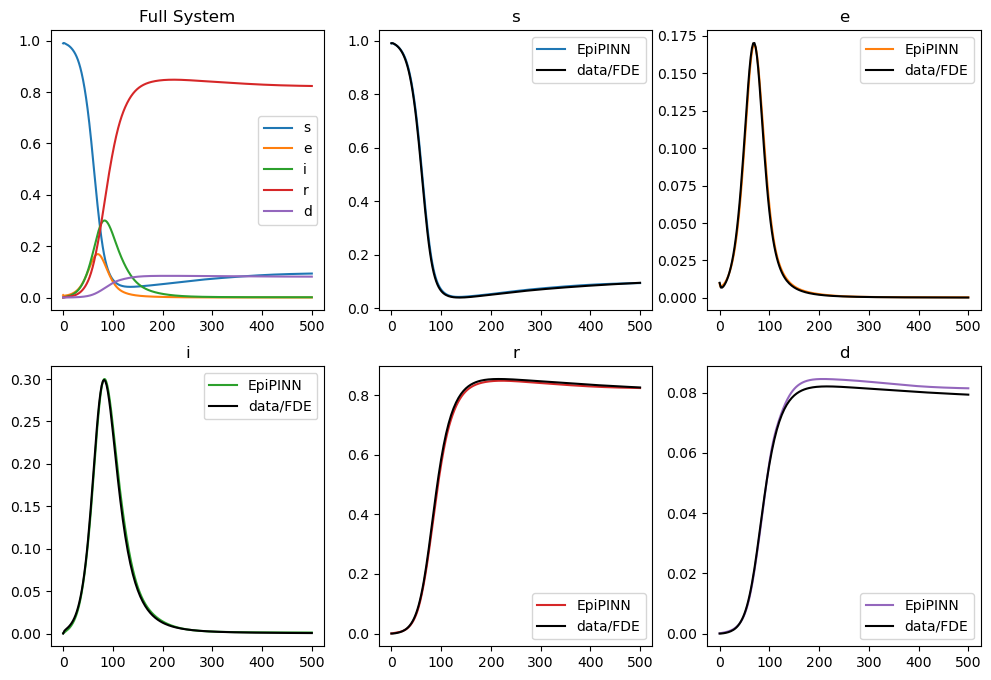

In [13]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

In [14]:
model1.get_loss_phys(ts_colloc)

tensor(3.5077e-06, grad_fn=<MeanBackward0>)

In [15]:
# Start timing
start2 = time.time()

# Stage 2: weights and epidemiological parameters, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-4),
    epochs=2000,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/2000], Loss: 0.000004
Epoch [200/2000], Loss: 0.000003
Epoch [300/2000], Loss: 0.000003
Epoch [400/2000], Loss: 0.000003
Epoch [500/2000], Loss: 0.000003
Epoch [600/2000], Loss: 0.000003
Epoch [700/2000], Loss: 0.000003
Epoch [800/2000], Loss: 0.000003
Epoch [900/2000], Loss: 0.000003
Epoch [1000/2000], Loss: 0.000002
Epoch [1100/2000], Loss: 0.000002
Epoch [1200/2000], Loss: 0.000002
Epoch [1300/2000], Loss: 0.000002
Epoch [1400/2000], Loss: 0.000002
Epoch [1500/2000], Loss: 0.000002
Epoch [1600/2000], Loss: 0.000002
Epoch [1700/2000], Loss: 0.000002
Epoch [1800/2000], Loss: 0.000002
Epoch [1900/2000], Loss: 0.000002
Epoch [2000/2000], Loss: 0.000002
Complete in 19.92497205734253 seconds
alpha = 0.9454740881919861
beta = 0.21309374272823334
gamma = 0.04375887289643288
sigma = 0.11021354794502258
mu = 0.004329973366111517


In [16]:
# Save model
torch.save(model1.state_dict(), 'experiment1.pth')

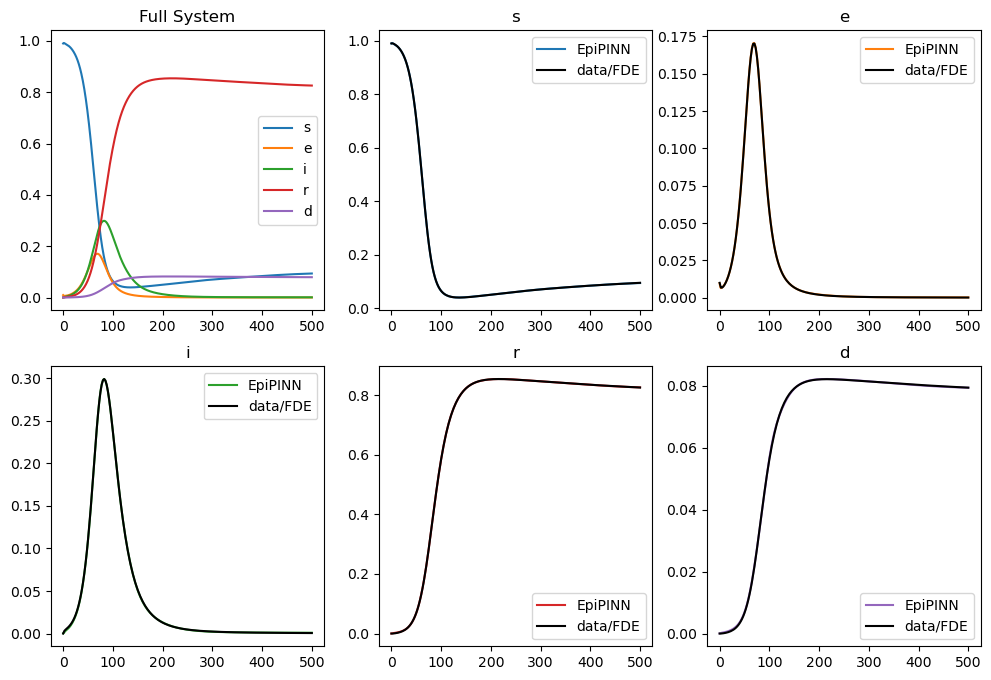

In [17]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

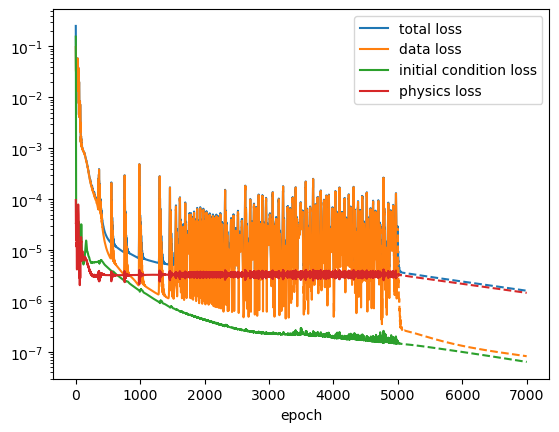

In [18]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

Text(0.5, 1.0, 'mu')

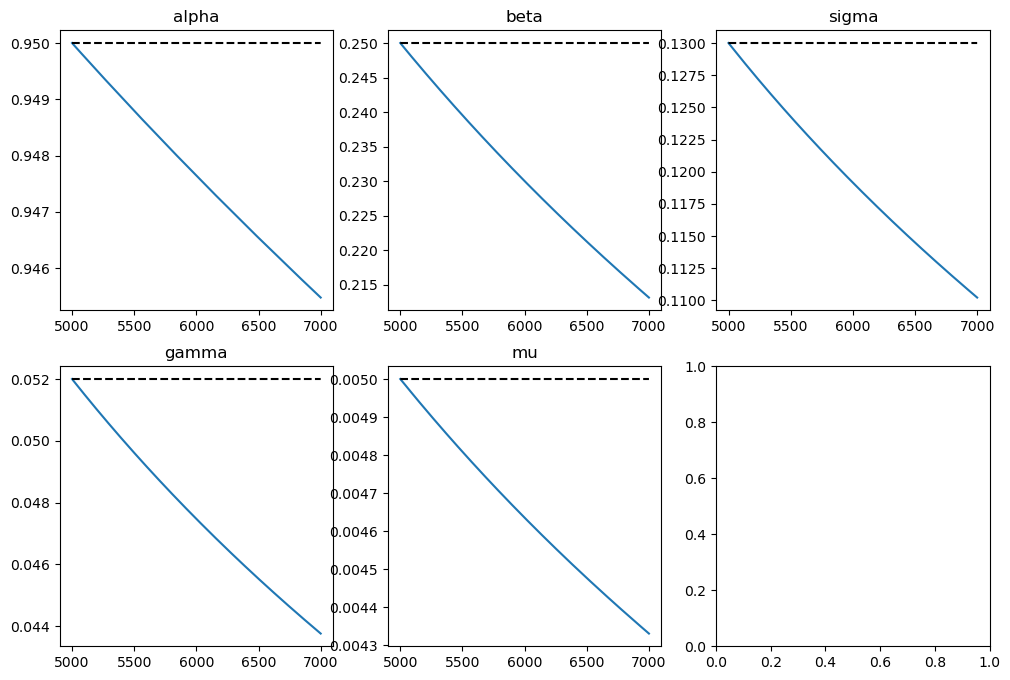

In [19]:
 # Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')

### Experiment 2: Parameter estimation with noisy data

This experiment is also a recreation of the Mpox synthetic case found in the paper. Now random noise is added to the data to test the model's abitilty to recover the ideal model.

In [20]:
def add_noise(ys, noise_level):
    """Add Gaussian noise to a signal.

    Args:
        ys (numpy.ndarray): The clean signal to which noise will be added.
        noise_level (float): Standard deviation of the Gaussian noise to add,
                             relative to the standard deviation of the input signal.

    Returns:
        numpy.ndarray: The noisy signal.
    """
    if noise_level <= 0.0:
        return ys
    # Calc magnitude based on standard deviation of the signal
    std_dev_ys = np.std(ys, axis=0 if ys.ndim > 1 else None)
    noise_scale = noise_level * np.where(std_dev_ys < 1e-10, 1.0, std_dev_ys)
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=ys.shape)
    ys_noisy = ys + noise

    return ys_noisy

In [21]:
def generate_true_data():
    # ranges determined by table 1 and 3
    alpha_min, alpha_max = 0.9, 1.0
    beta_min, beta_max = 0.1, 0.4
    sigma_min, sigma_max = 0.077, 0.3
    gamma_min, gamma_max = 0.036, 0.1
    mu_min, mu_max = 0.001, 0.03

    alpha_true = random.uniform(alpha_min, alpha_max)
    beta_true = random.uniform(beta_min, beta_max)
    sigma_true = random.uniform(sigma_min, sigma_max)
    gamma_true = random.uniform(gamma_min, gamma_max)
    mu_true = random.uniform(mu_min, mu_max)
    return alpha_true, beta_true, sigma_true, gamma_true, mu_true

In [22]:
# Data generation
alpha_true, beta_true, sigma_true, gamma_true, mu_true = generate_true_data()
print(f'True parameters: alpha={alpha_true:.4f}, beta={beta_true:.4f}, sigma={sigma_true:.4f}, gamma={gamma_true:.4f}, mu={mu_true:.4f}')

y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

# Add noise to data
noise_level = 0.1 # 10% noise
ys_noisy = add_noise(ys, noise_level)
ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys_noisy, dtype=torch.float32)

True parameters: alpha=0.9497, beta=0.1545, sigma=0.2687, gamma=0.0492, mu=0.0062
D[s] = -0.0, s = 0.99
D[s] = -0.001001266403505353, s = 0.9875602008613923
D[s] = -0.0011403894199200205, s = 0.9849485503949386
D[s] = -0.0013518932191563158, s = 0.9819038407616657
D[s] = -0.0015587006353800865, s = 0.9784362400681388
D[s] = -0.0017892317557086518, s = 0.9744866017895006
D[s] = -0.002046322074646656, s = 0.9699945906770215
D[s] = -0.0023345468020498274, s = 0.9648911807600852
D[s] = -0.002657600994877927, s = 0.9591003845165338
D[s] = -0.0030191112815513336, s = 0.9525390926433093
D[s] = -0.003422579284685964, s = 0.9451172518713714
D[s] = -0.0038713218075471035, s = 0.9367382444155397
D[s] = -0.004368330498496708, s = 0.9272996254145726
D[s] = -0.004916077508395434, s = 0.9166943189056519
D[s] = -0.005516266138307254, s = 0.9048123836508144
D[s] = -0.006169527832753425, s = 0.8915434591566513
D[s] = -0.006875069495035339, s = 0.8767799934658458
D[s] = -0.0076302811982127605, s = 0.8604

In [23]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.95 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.25 # Infection rate used for model
sigma_guess = 0.13 # Incubation rate used for model
gamma_guess = 0.052 # Recovery rate used for model
mu_guess = 0.005 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model_noisy = EpiPINN(hidden_size, depth, initial_params)

In [24]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model_noisy,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model_noisy.parameters(), lr=1e-2),
    epochs=2000,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model_noisy.alpha().item()}')
print(f'beta = {model_noisy.beta().item()}')
print(f'gamma = {model_noisy.gamma().item()}')
print(f'sigma = {model_noisy.sigma().item()}')
print(f'mu = {model_noisy.mu().item()}')

Epoch [100/2000], Loss: 0.000877
Epoch [200/2000], Loss: 0.000484
Epoch [300/2000], Loss: 0.000380
Epoch [400/2000], Loss: 0.000498
Epoch [500/2000], Loss: 0.000281
Epoch [600/2000], Loss: 0.000276
Epoch [700/2000], Loss: 0.000274
Epoch [800/2000], Loss: 0.000273
Epoch [900/2000], Loss: 0.000272
Epoch [1000/2000], Loss: 0.000272
Epoch [1100/2000], Loss: 0.000273
Epoch [1200/2000], Loss: 0.000274
Epoch [1300/2000], Loss: 0.000349
Epoch [1400/2000], Loss: 0.000315
Epoch [1500/2000], Loss: 0.000299
Epoch [1600/2000], Loss: 0.000278
Epoch [1700/2000], Loss: 0.000304
Epoch [1800/2000], Loss: 0.000294
Epoch [1900/2000], Loss: 0.000270
Epoch [2000/2000], Loss: 0.000277
Complete in 9.956048727035522 seconds
alpha = 0.949999988079071
beta = 0.25
gamma = 0.05199999734759331
sigma = 0.12999999523162842
mu = 0.004999999888241291


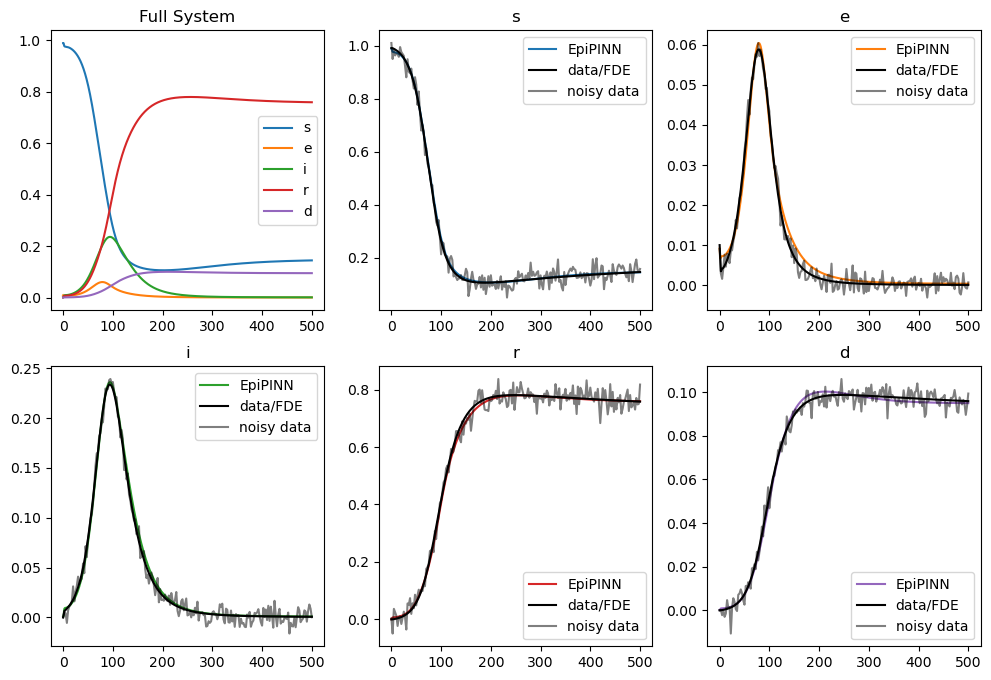

In [25]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model_noisy.eval()
with torch.no_grad():
    ys_val = model_noisy(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys_noisy[:, i], label='noisy data', color='k', alpha=0.5)


for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

In [26]:
# Start timing
start2 = time.time()

# Stage 2: weights and epidemiological parameters, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model_noisy,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model_noisy.parameters(), lr=1e-4),
    epochs=2000,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model_noisy.alpha().item()}')
print(f'beta = {model_noisy.beta().item()}')
print(f'gamma = {model_noisy.gamma().item()}')
print(f'sigma = {model_noisy.sigma().item()}')
print(f'mu = {model_noisy.mu().item()}')

Epoch [100/2000], Loss: 0.000281
Epoch [200/2000], Loss: 0.000280
Epoch [300/2000], Loss: 0.000279
Epoch [400/2000], Loss: 0.000278
Epoch [500/2000], Loss: 0.000278
Epoch [600/2000], Loss: 0.000277
Epoch [700/2000], Loss: 0.000277
Epoch [800/2000], Loss: 0.000276
Epoch [900/2000], Loss: 0.000275
Epoch [1000/2000], Loss: 0.000274
Epoch [1100/2000], Loss: 0.000274
Epoch [1200/2000], Loss: 0.000273
Epoch [1300/2000], Loss: 0.000272
Epoch [1400/2000], Loss: 0.000272
Epoch [1500/2000], Loss: 0.000271
Epoch [1600/2000], Loss: 0.000270
Epoch [1700/2000], Loss: 0.000270
Epoch [1800/2000], Loss: 0.000269
Epoch [1900/2000], Loss: 0.000268
Epoch [2000/2000], Loss: 0.000268
Complete in 18.31370711326599 seconds
alpha = 0.9453248381614685
beta = 0.21231767535209656
gamma = 0.0438762865960598
sigma = 0.15497930347919464
mu = 0.004244755022227764


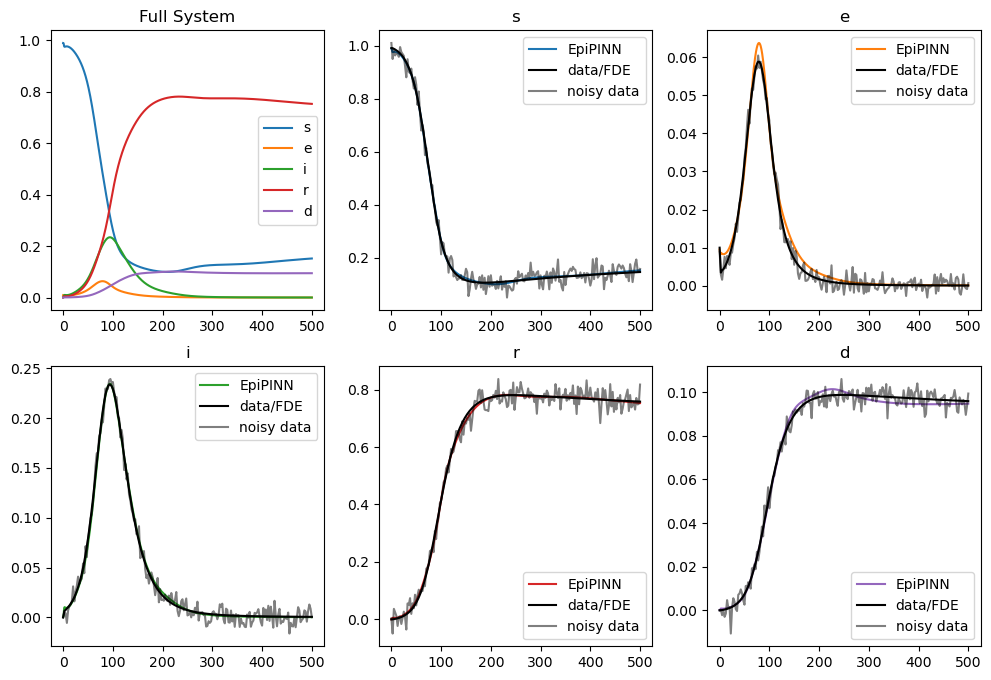

In [27]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model_noisy.eval()
with torch.no_grad():
    ys_val = model_noisy(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys_noisy[:, i], label='noisy data', color='k', alpha=0.5)


for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

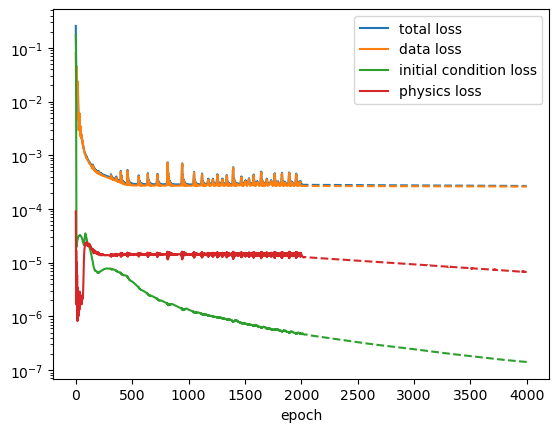

In [28]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

Text(0.5, 1.0, 'mu')

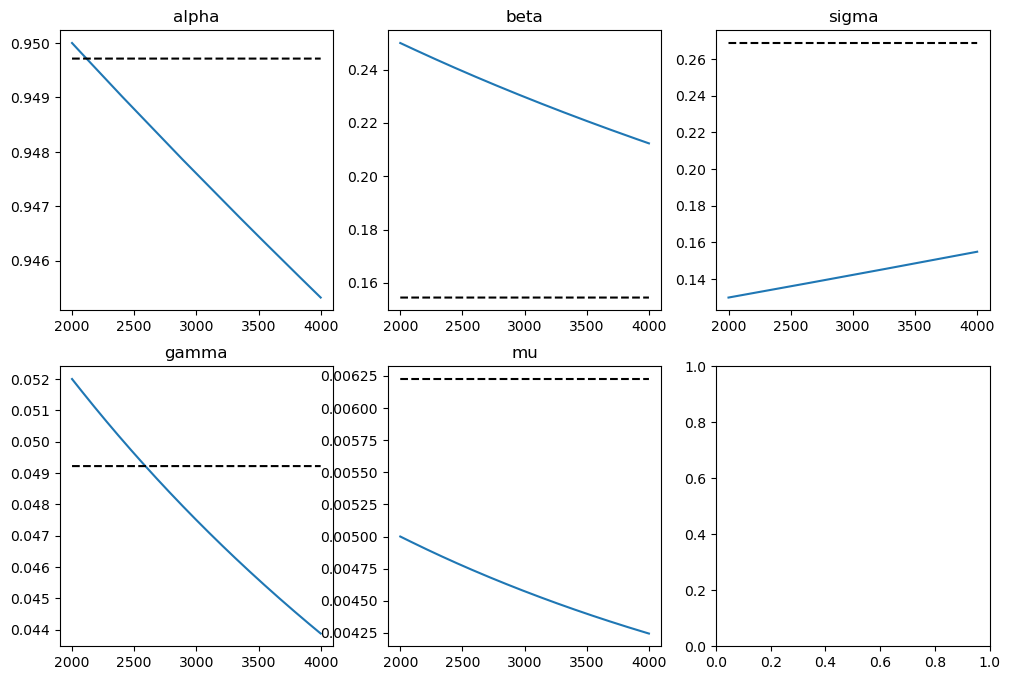

In [29]:
 # Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')

# Revised Experiment 1, freezing parameters

In [30]:
# Data generation
alpha_true = 0.95 # Derivative fraction used for data
beta_true = 0.25 # Infection rate used for model
sigma_true = 0.13 # Incubation rate used for model
gamma_true = 0.052 # Recovery rate used for model
mu_true = 0.005 # Death rate used for model
y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys, dtype=torch.float32)

D[s] = -0.0, s = 0.99
D[s] = -0.0007841305629861977, s = 0.9880890109096844
D[s] = -0.0011552957512042438, s = 0.9854036530858722
D[s] = -0.0014747388145720337, s = 0.9820474532817111
D[s] = -0.0018058120831112349, s = 0.9779884712069988
D[s] = -0.002177553004133218, s = 0.9731325089097256
D[s] = -0.0026069520732444483, s = 0.9673501488153666
D[s] = -0.0031074122108668404, s = 0.9604842071003005
D[s] = -0.0036914567130479645, s = 0.952351374039053
D[s] = -0.004371563257419124, s = 0.94274221864231
D[s] = -0.005160200306680222, s = 0.9314212831716681
D[s] = -0.006069391183102033, s = 0.9181282811684137
D[s] = -0.007109877002992552, s = 0.9025812701711294
D[s] = -0.008289861267395766, s = 0.8844827160715232
D[s] = -0.009613298609109951, s = 0.8635294474068337
D[s] = -0.011077713820837881, s = 0.8394275164141722
D[s] = -0.012671605298781214, s = 0.8119128391381225
D[s] = -0.014371607265886066, s = 0.7807780616211963
D[s] = -0.016139761945860632, s = 0.7459052677418145
D[s] = -0.0179214749

In [31]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.95 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.25 # Infection rate used for model
sigma_guess = 0.13 # Incubation rate used for model
gamma_guess = 0.052 # Recovery rate used for model
mu_guess = 0.005 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model1 = EpiPINN(hidden_size, depth, initial_params)

In [32]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-2),
    epochs=5000,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/5000], Loss: 0.000790
Epoch [200/5000], Loss: 0.000097
Epoch [300/5000], Loss: 0.000023
Epoch [400/5000], Loss: 0.000009
Epoch [500/5000], Loss: 0.000202
Epoch [600/5000], Loss: 0.000019
Epoch [700/5000], Loss: 0.000044
Epoch [800/5000], Loss: 0.000055
Epoch [900/5000], Loss: 0.000019
Epoch [1000/5000], Loss: 0.000076
Epoch [1100/5000], Loss: 0.000024
Epoch [1200/5000], Loss: 0.000002
Epoch [1300/5000], Loss: 0.000102
Epoch [1400/5000], Loss: 0.000012
Epoch [1500/5000], Loss: 0.000055
Epoch [1600/5000], Loss: 0.000007
Epoch [1700/5000], Loss: 0.000056
Epoch [1800/5000], Loss: 0.000003
Epoch [1900/5000], Loss: 0.000031
Epoch [2000/5000], Loss: 0.000055
Epoch [2100/5000], Loss: 0.000001
Epoch [2200/5000], Loss: 0.000002
Epoch [2300/5000], Loss: 0.000001
Epoch [2400/5000], Loss: 0.000064
Epoch [2500/5000], Loss: 0.000014
Epoch [2600/5000], Loss: 0.000103
Epoch [2700/5000], Loss: 0.000019
Epoch [2800/5000], Loss: 0.000005
Epoch [2900/5000], Loss: 0.000018
Epoch [3000/5000], Loss

In [33]:
# Freeze all parameters, weights and epidemiological parameters
# In the second stage, epidemiological parameters will be re-activated
for param in model1.parameters():
    param.requires_grad = False

In [34]:
# Start timing
start2 = time.time()

# Stage 2: epidemiological parameters ONLY, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-4),
    epochs=2000,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/2000], Loss: 0.000013
Epoch [200/2000], Loss: 0.000013
Epoch [300/2000], Loss: 0.000013
Epoch [400/2000], Loss: 0.000013
Epoch [500/2000], Loss: 0.000013
Epoch [600/2000], Loss: 0.000013
Epoch [700/2000], Loss: 0.000012
Epoch [800/2000], Loss: 0.000012
Epoch [900/2000], Loss: 0.000012
Epoch [1000/2000], Loss: 0.000012
Epoch [1100/2000], Loss: 0.000012
Epoch [1200/2000], Loss: 0.000012
Epoch [1300/2000], Loss: 0.000012
Epoch [1400/2000], Loss: 0.000012
Epoch [1500/2000], Loss: 0.000012
Epoch [1600/2000], Loss: 0.000012
Epoch [1700/2000], Loss: 0.000012
Epoch [1800/2000], Loss: 0.000012
Epoch [1900/2000], Loss: 0.000011
Epoch [2000/2000], Loss: 0.000011
Complete in 19.101917266845703 seconds
alpha = 0.945465624332428
beta = 0.21307380497455597
gamma = 0.043740153312683105
sigma = 0.11013060063123703
mu = 0.0043218061327934265


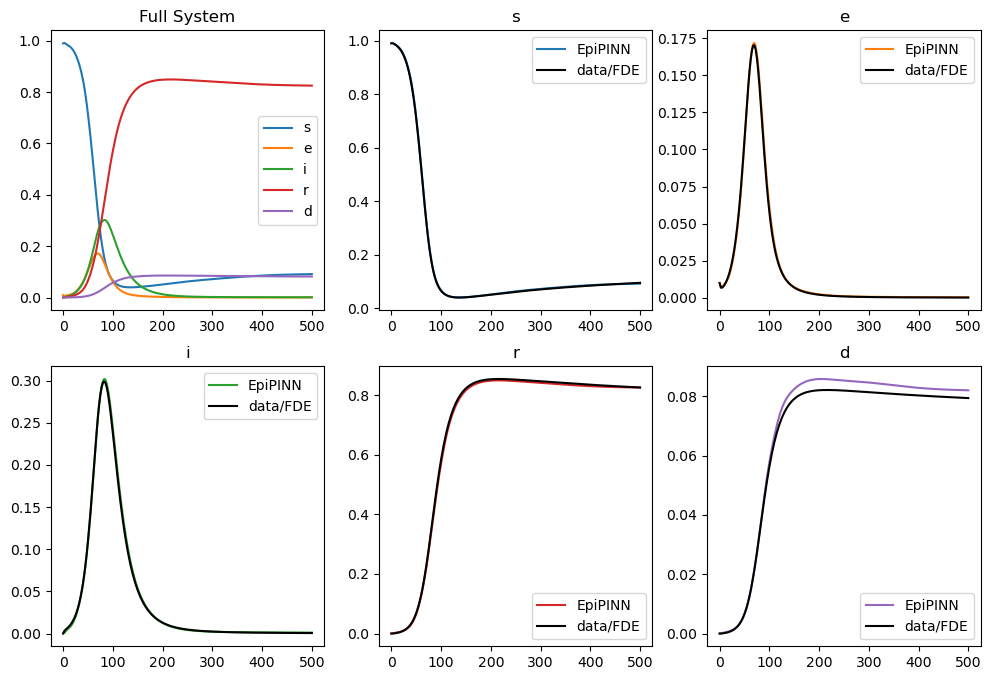

In [35]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

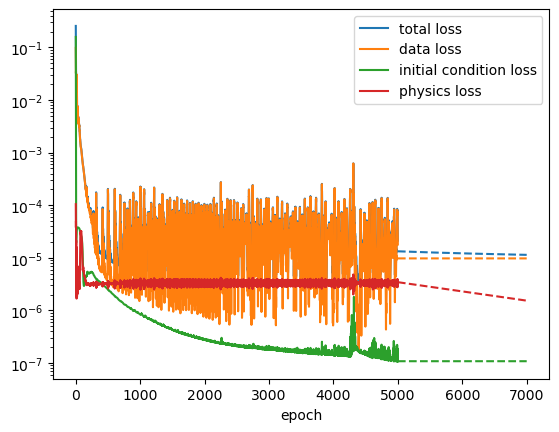

In [36]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

Text(0.5, 1.0, 'mu')

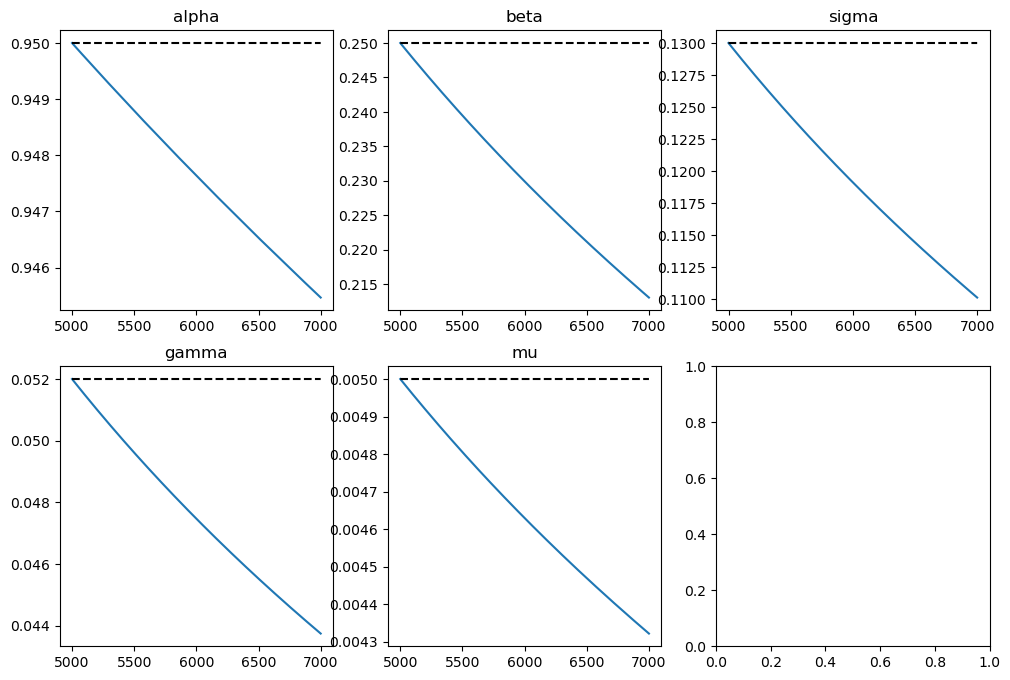

In [37]:
# Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')